In [15]:
import data
import data_hf
from modelling import model
import jax.numpy as jnp
import jax
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

from importlib import reload
model = reload(model)
data = reload(data)
data_hf = reload(data_hf)
import data_shae
data_shae = reload(data_shae)


In [16]:
cfg = model.Config(
    d_model=1024,
    ffw_multiplier=4,
    query_heads=8,
    key_heads=8,
    num_layers=8,
    key_dim=128,
    vocab_size=8,
    max_seq_len=8192,
    causal=False,
    use_attn_kernel=True,
    weight_dtype_at_rest=jnp.float32,
    active_weight_dtype=jnp.bfloat16,
    rules=model.fsdp_rules,
    mesh=model.create_mesh(),
    max_lr=3e-4,
    min_lr=3e-5,
    warmup_steps=50,
    total_steps=10000,
    mega_byte=True,
    patch_size=8,
    # data_shae ['unk']
    mask_token = 1
)


In [4]:
weights = model.Weights.init(cfg, jax.random.PRNGKey(0), cfg.mesh, model.fsdp_rules)
opt_state = model.init_adam_state(weights)

In [7]:
iter = data_shae.create_iterator(f"gs://minformer_data/shae_8k_v2/tfrecords/" + "record_*.tfrecord", batch_size=8, shuffle=True)

In [17]:
batch = model.process_batch_shae(next(iter), cfg, 0)
batch = jax.device_put(batch, model.input_shardings(cfg.mesh, cfg.rules))

In [18]:
batch

{'aux': {'bert_mask': Array([[ True, False, False, False, False,  True, False, False, False,  True, False, False, False, False, False, False,  True, False,  True,  True, False, False, False, False, False, False, False, False, False, False, ..., False, False,  True, False, False, False, False, False, False, False, False, False,  True, False, False, False, False, False,  True, False, False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False, False,  True, False, False, False, False,  True, False,  True, False, False, False, False, False, False, False, False,  True, False, False, ..., False, False, False, False, False,  True,  True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False,  True, False, False,  True, False, False, False, False],
         [False, False, False, False,  True, False, False, False, False, False, False, False, False, False, 

In [19]:
step = jax.jit(model.update_step, static_argnames='cfg')
step = step.lower(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, 0, cfg=cfg, aux=batch['aux']).compile()

In [22]:
from jax.profiler import trace
with trace("/tmp/profile"):
    loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, 0, aux=batch['aux'])
    loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, 0, aux=batch['aux'])
    jax.block_until_ready(loss)

In [23]:
# Does loss go down!
for i in range(0, 10000):
    batch = model.process_batch_shae(next(iter), cfg, 0)
    batch = jax.device_put(batch, model.input_shardings(cfg.mesh, cfg.rules))
    loss, weights, opt_state, internals = step(weights, batch['x'], batch['segment_ids'], batch['y'], opt_state, i, aux=batch['aux'])
    print(i, loss, internals['accuracy'])

0 2.7370906 0.14352173
1 2.7834382 0.15569633
2 2.345886 0.19360587
3 1.9194294 0.2645749
4 1.7673976 0.2802138
5 1.7095809 0.27229536
6 1.5978522 0.28031278
7 1.5192686 0.26239732
8 1.4651344 0.26952392
9 1.4670441 0.27793726
10 1.446618 0.2783332
11 1.4317198 0.27655154
12 1.4051127 0.30723548
13 1.4085292 0.2786301
14 1.3990364 0.29892114
15 1.3873334 0.3188162
16 1.4059769 0.29318026
17 1.3847693 0.30040583
18 1.3756051 0.30832428
19 1.3670012 0.31851926
20 1.3524804 0.3305949
21 1.3665587 0.32435912
22 1.3642629 0.33079284
23 1.3697145 0.31198657
24 1.3793343 0.30218747
25 1.3655471 0.31723252
26 1.3606695 0.32623973
27 1.3684692 0.320004
28 1.3774017 0.30238545
29 1.3549788 0.3173315
30 1.362595 0.32099378
31 1.3756984 0.3158468
32 1.3714479 0.3076314
33 1.3572427 0.3178264
34 1.3637003 0.32752648
35 1.350418 0.31950906
36 1.35054 0.3387113
37 1.3542302 0.34019598
38 1.3578069 0.31752947
39 1.3670516 0.3121845
40 1.9891182 0.2986242
41 1.3529141 0.32891223
42 1.3521016 0.33099082

ValueError: One of device_put args was given the sharding of NamedSharding(mesh=Mesh('x': 8), spec=PartitionSpec('x', None)), which implies that the global size of its dimension 0 should be divisible by 8, but it is equal to 2 (full shape: (2, 8192))

In [63]:
internals

{'accuracy': Array(0.415, dtype=float32),
 'grad_norms': Weights(layers=[Layer(q=Array(0.599, dtype=float32), k=Array(0.651, dtype=float32), v=Array(1.49, dtype=float32), proj=Array(1.51, dtype=float32), w1=Array(1.39, dtype=float32), w2=Array(1.55, dtype=float32), gamma1=Array(0.0772, dtype=float32), gamma2=Array(0.061, dtype=float32)), Layer(q=Array(0.24, dtype=float32), k=Array(0.299, dtype=float32), v=Array(0.814, dtype=float32), proj=Array(0.835, dtype=float32), w1=Array(1.06, dtype=float32), w2=Array(1.19, dtype=float32), gamma1=Array(0.0388, dtype=float32), gamma2=Array(0.0462, dtype=float32)), Layer(q=Array(0.18, dtype=float32), k=Array(0.216, dtype=float32), v=Array(0.726, dtype=float32), proj=Array(0.683, dtype=float32), w1=Array(0.89, dtype=float32), w2=Array(1.02, dtype=float32), gamma1=Array(0.0337, dtype=float32), gamma2=Array(0.0396, dtype=float32)), Layer(q=Array(0.149, dtype=float32), k=Array(0.18, dtype=float32), v=Array(0.643, dtype=float32), proj=Array(0.629, dtype=

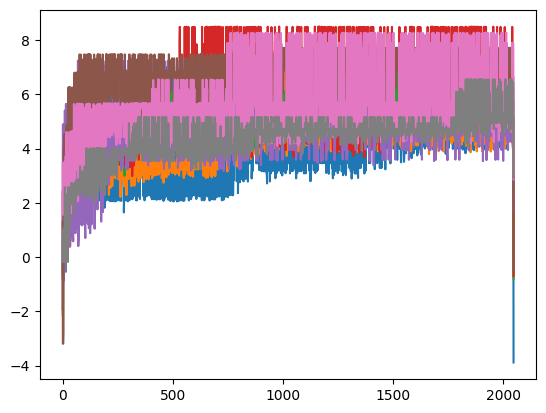

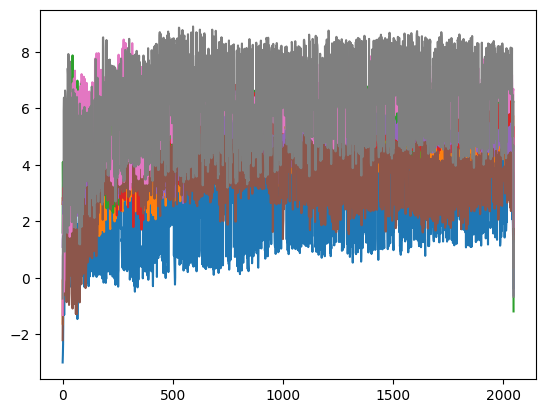

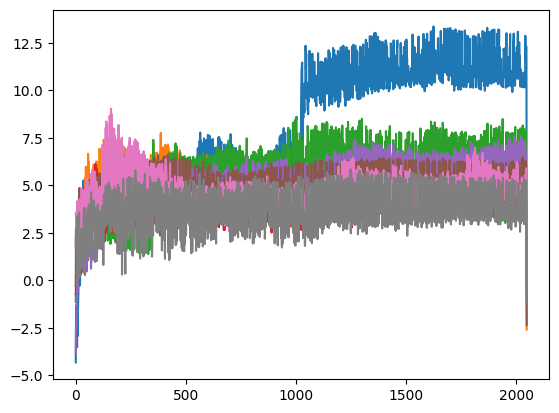

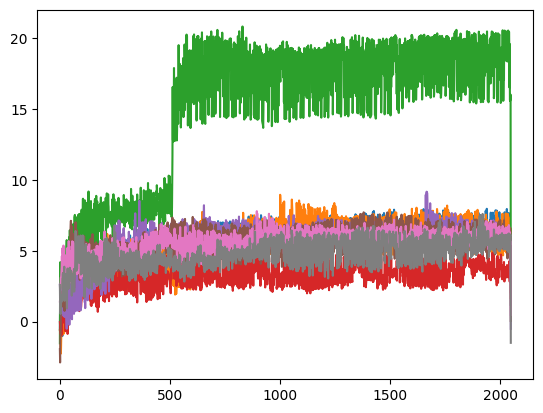

In [264]:
import matplotlib.pyplot as plt
batch_idx = 0
for layer in range(0, 4):
    for head in range(0, 8):
        plt.plot(internals['logit_max'][layer][batch_idx, head, :])
    plt.show()

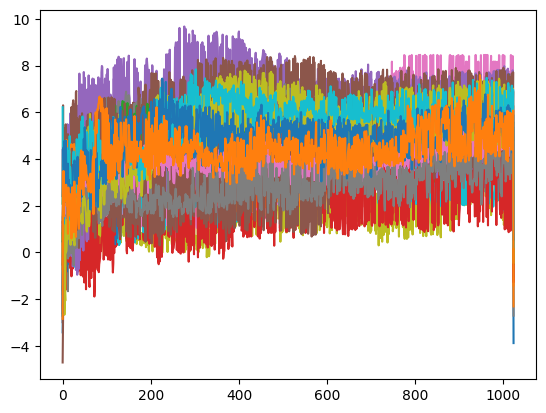

In [163]:
import matplotlib.pyplot as plt
batch_idx = 0
for layer in range(0, 4):
    for head in range(0, 8):
        plt.plot(internals['logit_max'][layer][batch_idx, head, :])

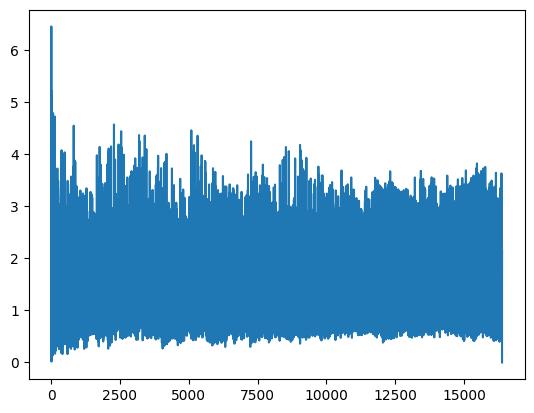

In [15]:

plt.plot(internals['per_token_loss'][2, :])